In [1]:
%load_ext autoreload

### Finding new Rfam families only

In [2]:
%autoreload
from rna2d.utils import Rfam

rfam142 = "../external-files/rfam-14.2/Rfam.pdb"
rfam148 = "../external-files/rfam-14.8/Rfam.pdb"

rfam = Rfam()
rfam2_mapping = rfam.get_pdb_family_mapping(rfam142)
rfam8_mapping = rfam.get_pdb_family_mapping(rfam148)
print(len(rfam2_mapping), len(rfam8_mapping))

5736 7659


In [3]:
%autoreload
rfam2_ids = set(rfam.get_families_ids(rfam142))
rfam8_ids = set(rfam.get_families_ids(rfam148))

a = rfam2_ids.difference(rfam8_ids)
b = rfam8_ids.difference(rfam2_ids)
i = rfam2_ids.intersection(rfam8_ids)

print(len(rfam2_ids), len(rfam8_ids))
print(f'2vs8: {len(a)}, 8vs2:{len(b)}, intersection:{len(i)}')
print(b)

rfam8_fams = rfam.get_pdb_family_mapping(rfam148, b)
print(len(rfam8_fams))


108 125
2vs8: 5, 8vs2:22, intersection:103
{'RF02678', 'RF00525', 'RF00030', 'RF00957', 'RF00240', 'RF00007', 'RF03054', 'RF02340', 'RF04190', 'RF00106', 'RF00507', 'RF00619', 'RF00075', 'RF01047', 'RF03013', 'RF01330', 'RF01357', 'RF00012', 'RF00024', 'RF01415', 'RF02681', 'RF01084'}
83


In [4]:
print(sorted(list(rfam2_mapping.keys()))[:10])
print(sorted(list(rfam8_mapping.keys()))[:10])

['1ASY_R', '1ASY_S', '1ASZ_R', '1ASZ_S', '1B23_R', '1C04_E', '1C0A_B', '1C2W_B', '1C2X_C', '1EFW_C']
['1ASY_R', '1ASY_S', '1ASZ_R', '1ASZ_S', '1B23_R', '1C04_E', '1C0A_B', '1C2W_B', '1C2X_C', '1EFW_C']


In [5]:
new_mapping = rfam.get_new_keys_only(rfam2_mapping, rfam8_mapping)
print(len(new_mapping))
print(sorted(list(new_mapping.keys()))[:10])

1977
['1M5K_B', '1M5K_E', '1M5O_B', '1M5O_E', '1M5P_B', '1M5P_E', '1M5V_B', '1M5V_E', '3IZZ_D', '4C9D_C']


### Remove SPOT-RNA training examples

In [6]:
import os
train_pdbs = "../external-files/PDB_dataset/TR1_sequences/"
def get_pdb_ids(path):
    pdbs = os.listdir(path)
    pdbs = [p.replace("-", "_") for p in pdbs]
    pdbs = [f'{p[:4].upper()}{p[4:]}' for p in pdbs]
    pdbs = [f'{p.split("_")[0]}_{p.split("_")[2]}' for p in pdbs]
    return pdbs

trpdbs = get_pdb_ids(train_pdbs)

nm = set(new_mapping.keys())
tp = set(trpdbs)
diff = nm.intersection(tp)
print(f'Common: {len(diff)}')

new_mapping = rfam.filter_out_list(trpdbs, new_mapping)
print(len(new_mapping))
print(sorted(trpdbs)[:5])

Common: 1
1976
['1C0A_B', '1DDY_A', '1DK1_B', '1DUL_B', '1FFK_9']


List of missing cif files

In [ ]:
new_cifs = os.listdir('/data/2d-rna/new-cifs/cifs')
cifs_ids = [x.replace('.cif', '') for x in new_cifs]
cifs_ids = [f'{p.split("_")[0]}_{p.split("_")[2]}' for p in cifs_ids]
out = []
out_ids = []
for a, b in zip(cifs_ids, new_cifs):
    if a in new_mapping:
        out.append(b)
        out_ids.append(a)

# for m in new_mapping:
#     if m not in cifs_ids:
#         print(m)

print(len(out))
print(out[:10])
print(out_ids[:10])

In [8]:
fams = [new_mapping[p] for p in new_mapping]

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

c = Counter(fams)
vals = list(c.values())
keys = list(c.keys())
vk = sorted(zip(keys, vals), key=lambda x : x[1], reverse=True)
keys = [x[0] for x in vk]
vals = [x[1] for x in vk]


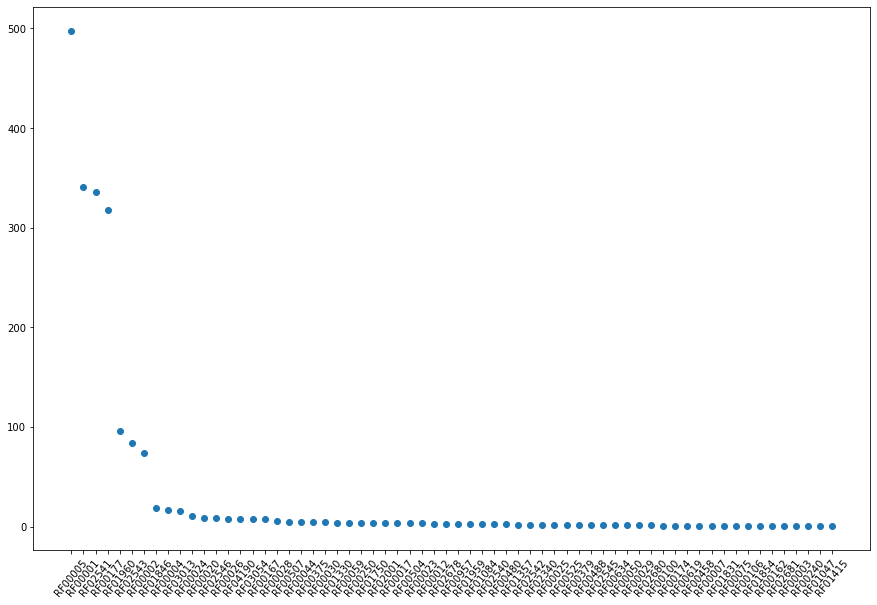

In [10]:
plt.figure(figsize=(15,10))
plt.scatter(keys, vals)
_ = plt.xticks(rotation=50)

In [11]:
from rna2d.pipelines import Pipeline
p = Pipeline("/data/2d-rna/validation-all-non0/results.rpt")
methods, indeces = p.run_for_all()
pdb_repres = [f'{p.split("_")[0]}_{p.split("_")[2]}' for p in indeces['spot-rna']]

In [13]:
import pandas as pd
from rna2d.utils import get_names
tool = 'e2efold'
converted_indeces = [f'{p.split("_")[0]}_{p.split("_")[2]}' for p in indeces[tool]]
common_ind = set(converted_indeces)
common_ind = list(common_ind.intersection(set(new_mapping.keys())))

print(len(set(out_ids).intersection(set(common_ind))))
# df = pd.DataFrame(methods[tool], columns=[
#                   'PPV', 'TPR', 'F1', 'INF'], index=indeces[tool])
# print(df['INF'].max())
# x = df.loc[df['INF']>0.9].head(100).tail()
# print(len(x))
print(f'Common ids: {len(common_ind)}')
res = {}
conv_ind = {}
for k in get_names():
    converted_indeces = [f'{p.split("_")[0]}_{p.split("_")[2]}' for p in indeces[k]]
    df = pd.DataFrame(methods[k], columns=[
                  'PPV', 'TPR', 'F1', 'INF'], index=converted_indeces)
    conv_ind[k]=converted_indeces
    res[k] =  df.loc[common_ind]

427
Common ids: 889


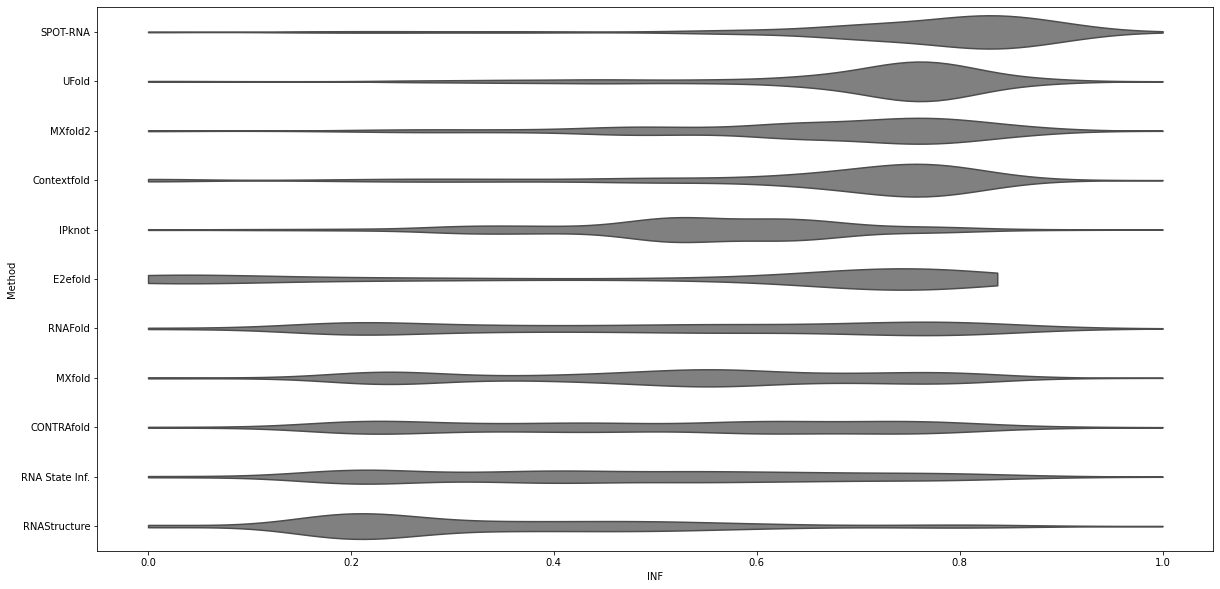

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from rna2d.utils import get_sns_data, get_means_stds, get_DataFrames

%autoreload
means, stds, dfs = get_means_stds(res, conv_ind)
dfmeans, dfstds = get_DataFrames(means, stds, name='nwc')

d = get_sns_data(res, dfmeans, get_names())

fig, axs = plt.subplots(1, figsize=(20, 10))
ax = sns.violinplot(x='INF', y='Method', inner=None, color='grey', data=d, ax=axs, cut=0)

In [89]:
dfmeans

,PPV,TPR,F1,INF
spot-rna,0.64,0.90,0.74,0.76
ufold,0.55,0.90,0.68,0.70
mxfold2,0.52,0.84,0.64,0.66
contextFold,0.50,0.85,0.63,0.65
ipknot,0.42,0.71,0.52,0.54
e2efold,0.39,0.70,0.50,0.52
rnafold,0.41,0.62,0.49,0.51
mxfold,0.39,0.68,0.49,0.51
contrafold,0.40,0.61,0.48,0.50
rna-state-inf,0.36,0.57,0.44,0.45


In [85]:
res['rna-structure']


,PPV,TPR,F1,INF
7B7D_LB,0.838,0.838,0.838,0.838
7P3K_V,0.857,1.000,0.923,0.926
7NRD_LB,0.829,0.829,0.829,0.829
6ZMW_w,0.579,0.647,0.611,0.612
6XII_d,0.257,0.250,0.254,0.254
...,...,...,...,...
7K52_5,0.952,1.000,0.976,0.976
6WDC_7,0.909,1.000,0.952,0.953
7MSC_B,0.903,1.000,0.949,0.950
6XHV_1y,0.905,1.000,0.950,0.951
